# Hand Gesture Classification Using MediaPipe Landmarks

## Project Overview
This project classifies **18 hand gestures** using landmark data generated by **MediaPipe** from the [HaGRID](https://github.com/hukenovs/hagrid) (Hand Gesture Recognition Image Dataset).

- **Input:** A CSV file containing 21 hand landmarks × (x, y, z) coordinates extracted using MediaPipe — **63 raw features** per sample.
- **Output:** A trained ML model achieving **>98% accuracy** on 18-class gesture recognition, with a real-time video inference pipeline.

## Dataset Details
The HaGRID dataset contains **18 hand gesture classes**:

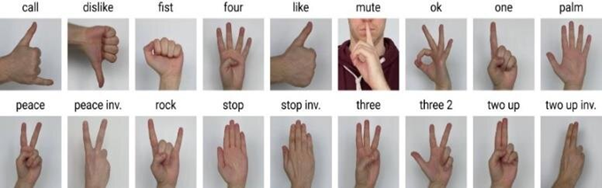

Each gesture is captured at varying hand positions, scales, and orientations. MediaPipe extracts **21 keypoints** per hand, each with (x, y, z) coordinates.

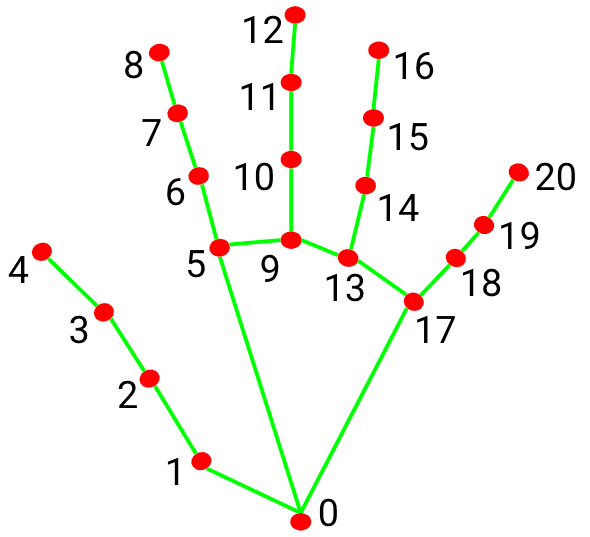

## Notebook Pipeline

| Step | Description |
|------|-------------|
| 1. Import & Setup | Load libraries, initialize MediaPipe |
| 2. Load & Preprocess | Normalize landmarks; engineer geometric features |
| 3. EDA | Explore class distribution and dataset statistics |
| 4. Visualization | Compare raw vs. processed landmark plots |
| 5. Model Training | Train and compare multiple ML classifiers |
| 6. MLflow Tracking | Log all experiments for full reproducibility |
| 7. Video Inference | Run the best model on a real input video |

## Output Video

https://drive.google.com/file/d/148F5odFyvRgWYuDn_o8wLK9gp02ysvcz/view

# Import Libraries

Uncomment the following cell to install any missing dependencies

In [1]:
# !pip install mediapipe==0.10.14 opencv-python pandas scikit-learn matplotlib seaborn mlflow -q

Uncomment the following cell to install the dataset

In [2]:
# !gdown https://drive.google.com/file/d/1cHrLgf_7xScBHxnvnlCkvAy_iYGscN3w

In [3]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

## Preprocessing


**1. Recenter**  
Subtract the wrist landmark from all 21 landmarks, the wrist becomes the origin

**2. Scale**  
Divide all landmarks by the Euclidean distance to the middle finger tip (landmark 12) → hands of all sizes map to the same unit scale.

**3. Feature Engineering**  
On top of the **63 normalized coordinates (21 × 3)**, we compute **20 additional geometric features**:

- Fingertip pair distances (10): Euclidean distances between all fingertip pairs
- Fingertip-to-wrist distances (5): How far each fingertip is from the wrist origin
- Finger foldedness scores (5): Tip-to-wrist dist minus PIP-to-wrist dist (negative = curled)

In [4]:
# def preprocess_landmarks(row_or_landmarks):
#     # Reshape flat array into (21, 3) for easier manipulation
#     points = np.array(row_or_landmarks).reshape(21, 3)
    
#     # Landmark 0 is the wrist, Landmark 12 is the middle finger tip
#     wrist = points[0]

#     centered_points = points - wrist

#     mid_finger_tip = centered_points[12]
#     scale_factor = np.linalg.norm(mid_finger_tip) + 1e-6 # Prevent division by zero
    
#     normalized_points = centered_points / scale_factor
    
#     # Flatten back to 63 values
#     return normalized_points.flatten()

In [5]:
from itertools import combinations

def preprocess_and_engineer(row_or_landmarks):
    """
    1. Recenters to wrist.
    2. Scales by mid-finger tip.
    3. Engineers specific hand-geometry features.
    """
    # Reshape flat array into (21, 3)
    points = np.array(row_or_landmarks).reshape(21, 3)
    wrist = points[0]
    
    # 1 & 2: Recenter and Scale
    centered_points = points - wrist
    mid_finger_tip = centered_points[12]
    scale_factor = np.linalg.norm(mid_finger_tip) + 1e-6
    normalized_points = centered_points / scale_factor
    
    # Start our feature list with the 63 normalized coordinates
    features = list(normalized_points.flatten())
    
    # --- FEATURE ENGINEERING ---
    
    # Key landmark indices
    # Thumb: 4, Index: 8, Middle: 12, Ring: 16, Pinky: 20
    fingertips = [4, 8, 12, 16, 20]
    
    # Feature A: Distances between all pairs of fingertips (10 features)
    for i, j in combinations(fingertips, 2):
        dist = np.linalg.norm(normalized_points[i] - normalized_points[j])
        features.append(dist)
        
    # Feature B: Distance from each fingertip to the wrist (5 features)
    # Since wrist is at (0,0,0) after centering, it's just the norm of the tip
    for tip in fingertips:
        features.append(np.linalg.norm(normalized_points[tip]))
        
    # Feature C: Finger "Foldedness" (5 features)
    # Compares the distance of the tip to the wrist vs the PIP (middle joint) to the wrist
    pips = [3, 6, 10, 14, 18] # Middle knuckles for each finger
    for tip, pip in zip(fingertips, pips):
        tip_dist = np.linalg.norm(normalized_points[tip])
        pip_dist = np.linalg.norm(normalized_points[pip])
        # If tip_dist - pip_dist is negative, the finger is folded inward
        features.append(tip_dist - pip_dist)
        
    return np.array(features)

# Load and Preprocess Data

load csv, preprocessing each row in the dataframe, then encoding using labelencoder for sklearn compability

In [6]:
# 1. Load Data
df = pd.read_csv('hand_landmarks_data.csv')

# Separate features (X) and labels (y)
X_raw = df.drop(columns=['label']).values
y_raw = df['label'].values

# 2. Apply Custom Preprocessing
X_processed = np.array([preprocess_and_engineer(row) for row in X_raw])

# 3. Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)

df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


## Preprocessing Visualization

We plot 4 gesture classes side-by-side — **before** (raw pixel coordinates) vs. **after** normalization — to verify that the pipeline works as expected.
- the green fingers are extended
- the red lines are folded fingers (fingertip closer from wrist than its middle knuckle)
- blue square is for the wrist landmark and it is converted to the origin point after centering


After preprocessing, all hands are centered at the origin and scaled to a consistent unit size, making the model position- and scale-invariant
regardless of where or how large the hand appears in the original image.

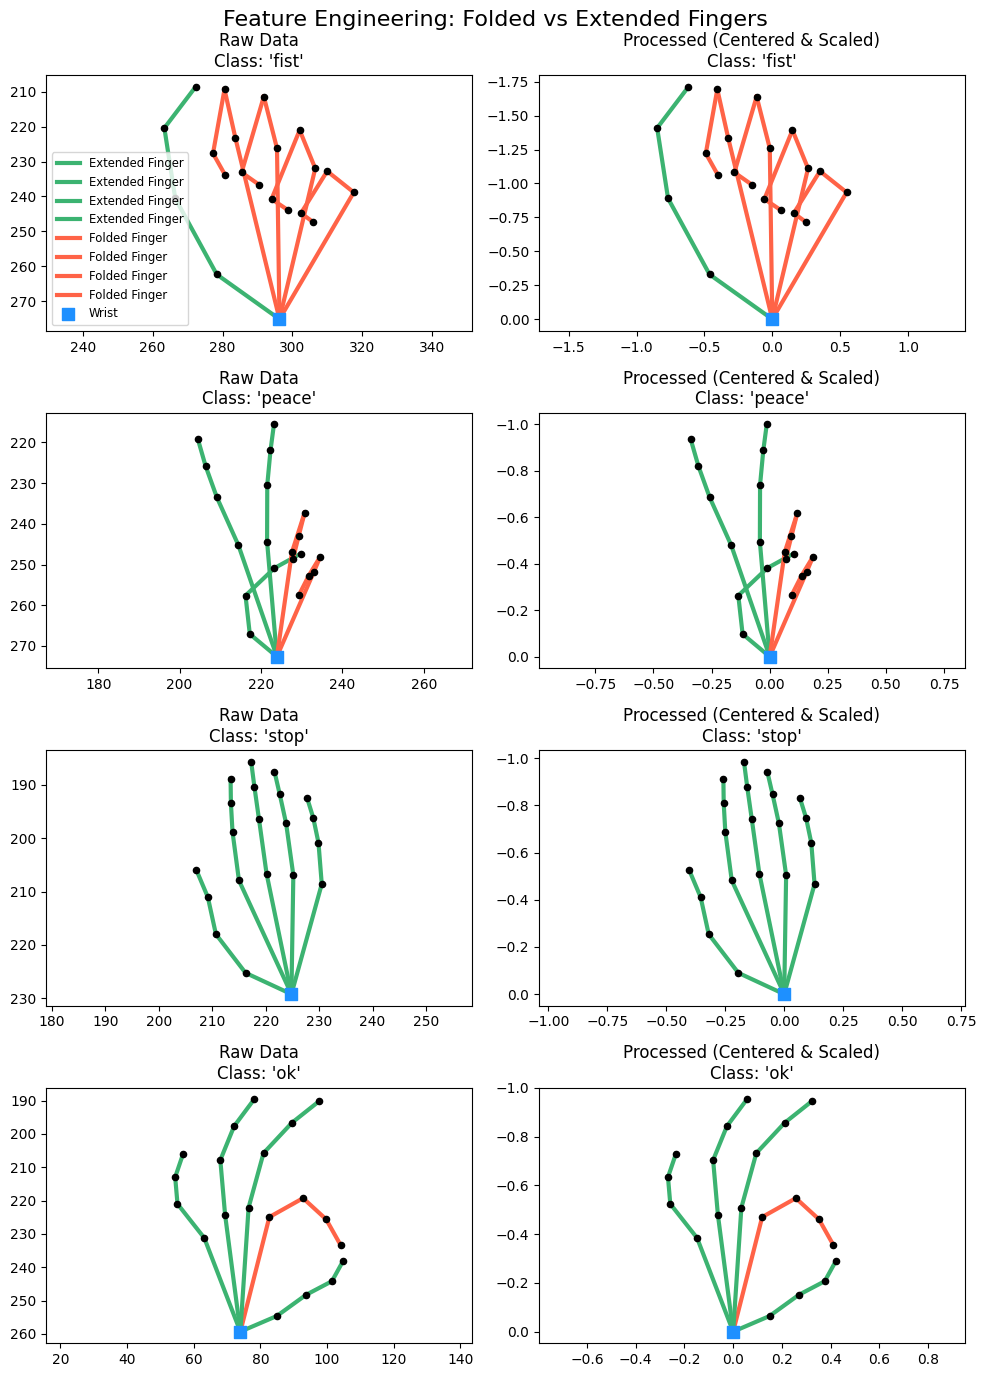

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 3. Define finger structures and key joints
fingers = {
    'Thumb':  {'connections': [(0, 1), (1, 2), (2, 3), (3, 4)],        'tip': 4,  'pip': 3},
    'Index':  {'connections': [(0, 5), (5, 6), (6, 7), (7, 8)],        'tip': 8,  'pip': 6},
    'Middle': {'connections': [(0, 9), (9, 10), (10, 11), (11, 12)],   'tip': 12, 'pip': 10},
    'Ring':   {'connections': [(0, 13), (13, 14), (14, 15), (15, 16)], 'tip': 16, 'pip': 14},
    'Pinky':  {'connections': [(0, 17), (17, 18), (18, 19), (19, 20)], 'tip': 20, 'pip': 18}
}

# 4. Smart Plotting Function with Logic
def plot_hand_smart(ax, points, title, invert_y=False):
    x = points[:, 0]
    y = points[:, 1]
    
    # Track legends so we only label them once
    added_extended = False
    added_folded = False
    
    # Check each finger and draw it
    for finger_name, data in fingers.items():
        tip_idx = data['tip']
        pip_idx = data['pip']
        
        # --- FEATURE ENGINEERING LOGIC ---
        # Is the distance from Tip to Wrist less than PIP to Wrist?
        dist_tip = np.linalg.norm(points[tip_idx] - points[0])
        dist_pip = np.linalg.norm(points[pip_idx] - points[0])
        is_folded = dist_tip < dist_pip
        
        # Color coding
        if is_folded:
            color = 'tomato'       # Red
            label = 'Folded Finger' if not added_folded else ""
            added_folded = True
        else:
            color = 'mediumseagreen' # Green
            label = 'Extended Finger' if not added_extended else ""
            added_extended = True
            
        # Draw the bones
        for connection in data['connections']:
            ax.plot([x[connection[0]], x[connection[1]]], 
                    [y[connection[0]], y[connection[1]]], 
                    c=color, linewidth=3, zorder=1, label=label if label != "" else "_nolegend_")

    # Plot joints (black dots)
    ax.scatter(x, y, c='black', s=20, zorder=5)
    
    # Mark wrist (blue square)
    ax.scatter(x[0], y[0], c='dodgerblue', s=80, zorder=6, marker='s', label='Wrist')
    
    ax.set_title(title, fontsize=12)
    ax.axis('equal') 
    if invert_y:
        ax.invert_yaxis()

# 5. Plotting execution
selected_classes = ['fist', 'peace', 'stop', 'ok'] 
fig, axes = plt.subplots(len(selected_classes), 2, figsize=(10, 14))
fig.suptitle("Feature Engineering: Folded vs Extended Fingers", fontsize=16)

for i, label in enumerate(selected_classes):
    # Pick random sample
    sample_row = df[df['label'] == label].sample(1, random_state=42).drop(columns=['label']).values[0]
    
    # Prepare points
    raw_points = sample_row.reshape(21, 3)
    # preprocess_and_engineer returns 83 features; first 63 are the (21x3) normalized coordinates
    processed_points = preprocess_and_engineer(sample_row)[:63].reshape(21, 3)
    
    # Plot Left (Raw)
    plot_hand_smart(axes[i, 0], raw_points, title=f"Raw Data\nClass: '{label}'", invert_y=True)
    if i == 0:
        axes[i, 0].legend(loc='lower left', fontsize='small')
    
    # Plot Right (Processed)
    plot_hand_smart(axes[i, 1], processed_points, title=f"Processed (Centered & Scaled)\nClass: '{label}'", invert_y=True)

plt.tight_layout()
plt.show()


split data with test size of 20%

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

## Systematic Baseline Comparison

We compare 3 classifiers: Random Forest, SVM (RBF kernel), and Logistic Regression

Each model is evaluated on the held-out test set (20%), reporting four metrics:
- **Accuracy**: Overall fraction of correctly classified samples
- **Precision**: Of all predicted positives, how many were actually correct
- **Recall**: Of all true positives, how many were successfully captured
- **F1-Score**: Harmonic mean of Precision and Recall, robust to class imbalance

In [9]:


# # Define 3 Models
# models = {
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
#     "SVM (SVC)": SVC(kernel='rbf', probability=True, random_state=42),
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
# }

# # Train and Evaluate
# results = []
# best_model = None
# best_acc = 0

# print("--- Model Evaluation Results ---")
# for name, model in models.items():
#     # Train
#     model.fit(X_train, y_train)
    
#     # Predict
#     y_pred = model.predict(X_test)
    
#     # Metrics
#     acc = accuracy_score(y_test, y_pred)
#     prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
#     rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
#     f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
#     results.append({
#         "Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1
#     })
    
#     print(f"\n{name}:")
#     print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    
#     # Save the best model
#     if acc > best_acc:
#         best_acc = acc
#         best_model = model

# # Display Comparison
# results_df = pd.DataFrame(results).set_index("Model")
# print("\nSummary Table:")
# display(results_df)

# # Save the best model and label encoder for the video inference
# with open('best_gesture_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le, f)
    
# print(f"\n✅ Best model '{results_df['Accuracy'].idxmax()}' saved to disk!")

## More model trial and Comparison

We are comparing between 6 classifiers including ensemble variants (Extra Trees, CatBoost-style HistGBM) and pipelines that add StandardScaler preprocessing before SVM and Logistic Regression.

In [10]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the models to compare
models = {
    'Gradient Boosting (Hist)':    HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, random_state=42),
    'Random Forest (Gini)':        RandomForestClassifier(n_estimators=300, criterion='gini', n_jobs=-1, random_state=42),
    'Random Forest (Entropy)':     RandomForestClassifier(n_estimators=300, criterion='entropy', n_jobs=-1, random_state=42),
    'Extra Trees (Gini)':          ExtraTreesClassifier(n_estimators=300, criterion='gini', n_jobs=-1, random_state=42),
    'Support Vector Machine (RBF)': make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42)),
    'Logistic Regression':         make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)),
}

# List to store the evaluation metrics
results = []

print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"Fitting: {name}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    # Using average='weighted' to account for multiclass gesture data
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Append to results
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# Convert to DataFrame, sort by Accuracy (highest first), and display
summary_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\nModel Comparison Summary:")
display(summary_df)

Training and evaluating models...

Fitting: Gradient Boosting (Hist)
Fitting: Random Forest (Gini)
Fitting: Random Forest (Entropy)
Fitting: Extra Trees (Gini)
Fitting: Support Vector Machine (RBF)
Fitting: Logistic Regression

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1-Score
0,Gradient Boosting (Hist),0.986173,0.986279,0.986173,0.986187
1,Random Forest (Gini),0.986173,0.986233,0.986173,0.986186
2,Logistic Regression,0.985200,0.985275,0.985200,0.985204
3,Random Forest (Entropy),0.984421,0.984514,0.984421,0.984440
4,Extra Trees (Gini),0.984226,0.984345,0.984226,0.984238
5,Support Vector Machine (RBF),0.982668,0.982910,0.982668,0.982689


All of the models were performing really well >98%, with gradient boosting performing slightly better  
so we will save the gradient boosting model

In [13]:
with open("best_gesture_model.pkl", 'wb') as file:
    pickle.dump(models[summary_df.loc[0, 'Model']], file)

In [ ]:
print(X_train.shape, y_train.shape)

(20540, 83) (20540,)


## Video Inference Pipeline
- load the input video an parse it frame by frame
- each frame is passes through mediapipe then the landmarks are preprocessed then passed to the ML model
- prediction is visualized on the video output

In [ ]:
# Load the saved model and encoder
with open('best_gesture_model.pkl', 'rb') as f:
    clf = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Input and Output video paths
video_path = 'input.mp4'
output_path = 'output_gesture_result.mp4'

cap = cv2.VideoCapture(video_path)

# Get video properties for saving
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Setup VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Initialize MediaPipe Hands
with mp_hands.Hands(
    model_complexity=1, 
    min_detection_confidence=0.7, 
    min_tracking_confidence=0.7,
    max_num_hands=2) as hands:
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert the BGR image to RGB
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                
                # 1. Extract raw landmarks into a list
                raw_landmarks = []
                for lm in hand_landmarks.landmark:
                    # MediaPipe gives normalized coordinates (0.0 to 1.0)
                    # We can use them directly since our preprocess function handles scaling
                    raw_landmarks.extend([lm.x, lm.y, lm.z])
                
                # 2. Preprocess exactly like the training data
                processed_landmarks = preprocess_and_engineer(raw_landmarks)
                
                # 3. Predict the gesture
                # Reshape for sklearn: (1, 63)
                prediction = clf.predict(processed_landmarks.reshape(1, -1))
                gesture_name = encoder.inverse_transform(prediction)[0]
                
                # 4. Draw landmarks and bounding box / text on the frame
                mp_drawing.draw_landmarks(
                    frame, 
                    hand_landmarks, 
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )
                
                # Calculate text position (using the wrist coordinate mapped to image dimensions)
                wrist_x = int(hand_landmarks.landmark[0].x * width)
                wrist_y = int(hand_landmarks.landmark[0].y * height)
                
                # Overlay the predicted gesture name
                cv2.putText(frame, gesture_name, (wrist_x, wrist_y - 20), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)

        # Write the processed frame to the output video
        out.write(frame)

# Release resources
cap.release()
out.release()
print(f"✅ Video processing complete! Saved to {output_path}")

✅ Video processing complete! Saved to output_gesture_result.mp4
